# Time Series Forecasting using HoltWinters and Decompose

# Global data 

In [1]:
dataUrl = paste("http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip")

# Read the Energy Consumption Data

In [2]:
temp <- tempfile()
download.file(dataUrl, temp)
PowerConsumption <- read.table(
  unz(
    temp,
    "household_power_consumption.txt"
  ),
  sep=";",
  header=TRUE,
  as.is=TRUE
)

# Create one date + time column called "DateTime"

In [3]:
PowerConsumption <-cbind(PowerConsumption,paste(PowerConsumption$Date,PowerConsumption$Time), 
            stringsAsFactors=FALSE)
colnames(PowerConsumption)[10] <-"DateTime"

# Move DateTime column to col 1 of the table

In [4]:
PowerConsumption <- PowerConsumption[,c(ncol(PowerConsumption), 1:(ncol(PowerConsumption)-1))]
head(PowerConsumption)

DateTime,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
16/12/2006 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17
16/12/2006 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16
16/12/2006 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17
16/12/2006 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17
16/12/2006 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17
16/12/2006 17:29:00,16/12/2006,17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17


# Remove the old date and time columns

In [5]:
PowerConsumption <- PowerConsumption[,-c(2:3)]
head(PowerConsumption)

DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
16/12/2006 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17
16/12/2006 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16
16/12/2006 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17
16/12/2006 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17
16/12/2006 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17
16/12/2006 17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17


# Convert date and Time from chr to POSIXlt object

In [6]:
PowerConsumption$DateTime <- strptime(PowerConsumption$DateTime, "%d/%m/%Y %H:%M:%S")

In [7]:
str(PowerConsumption)

'data.frame':	2075259 obs. of  8 variables:
 $ DateTime             : POSIXlt, format: "2006-12-16 17:24:00" "2006-12-16 17:25:00" ...
 $ Global_active_power  : chr  "4.216" "5.360" "5.374" "5.388" ...
 $ Global_reactive_power: chr  "0.418" "0.436" "0.498" "0.502" ...
 $ Voltage              : chr  "234.840" "233.630" "233.290" "233.740" ...
 $ Global_intensity     : chr  "18.400" "23.000" "23.000" "23.000" ...
 $ Sub_metering_1       : chr  "0.000" "0.000" "0.000" "0.000" ...
 $ Sub_metering_2       : chr  "1.000" "1.000" "2.000" "1.000" ...
 $ Sub_metering_3       : num  17 16 17 17 17 17 17 17 17 16 ...


# Convert data to numeric

In [8]:
PowerConsumption$Voltage<-as.numeric(as.character(PowerConsumption$Voltage))
PowerConsumption$Global_active_power<-as.numeric(as.character(PowerConsumption$Global_active_power))
PowerConsumption$Global_reactive_power<-as.numeric(as.character(PowerConsumption$Global_reactive_power))
PowerConsumption$Global_intensity<-as.numeric(as.character(PowerConsumption$Global_intensity))
PowerConsumption$Sub_metering_1<-as.numeric(as.character(PowerConsumption$Sub_metering_1))
PowerConsumption$Sub_metering_2<-as.numeric(as.character(PowerConsumption$Sub_metering_2))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [9]:
PowerConsumption[1:10,c("DateTime", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3")]

DateTime,Sub_metering_1,Sub_metering_2,Sub_metering_3
2006-12-16 17:24:00,0,1,17
2006-12-16 17:25:00,0,1,16
2006-12-16 17:26:00,0,2,17
2006-12-16 17:27:00,0,1,17
2006-12-16 17:28:00,0,1,17
2006-12-16 17:29:00,0,2,17
2006-12-16 17:30:00,0,1,17
2006-12-16 17:31:00,0,1,17
2006-12-16 17:32:00,0,1,17
2006-12-16 17:33:00,0,2,16


# Create year / month / day features

In [10]:
PowerConsumption$year <- as.factor(strftime(PowerConsumption[,1], format="%Y"))
PowerConsumption$month <- as.factor(strftime(PowerConsumption[,1], format="%b"))
PowerConsumption$dayOfMonth <- as.factor(strftime(PowerConsumption[,1], format="%e"))
PowerConsumption$hour <- as.factor(strftime(PowerConsumption[,1], format="%k"))

In [11]:
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Day One data

In [12]:
Powerdata_day <- PowerConsumption[,2:12] %>%
  group_by(year, month, dayOfMonth, hour) %>%
  summarise(SM1=sum(Sub_metering_1, na.rm=TRUE),
            SM2=sum(Sub_metering_3, na.rm=TRUE),
            SM3=sum(Sub_metering_2, na.rm=TRUE))
TS_day<-ts(Powerdata_day[1:24,5:7], frequency=24, start=0, end=23)

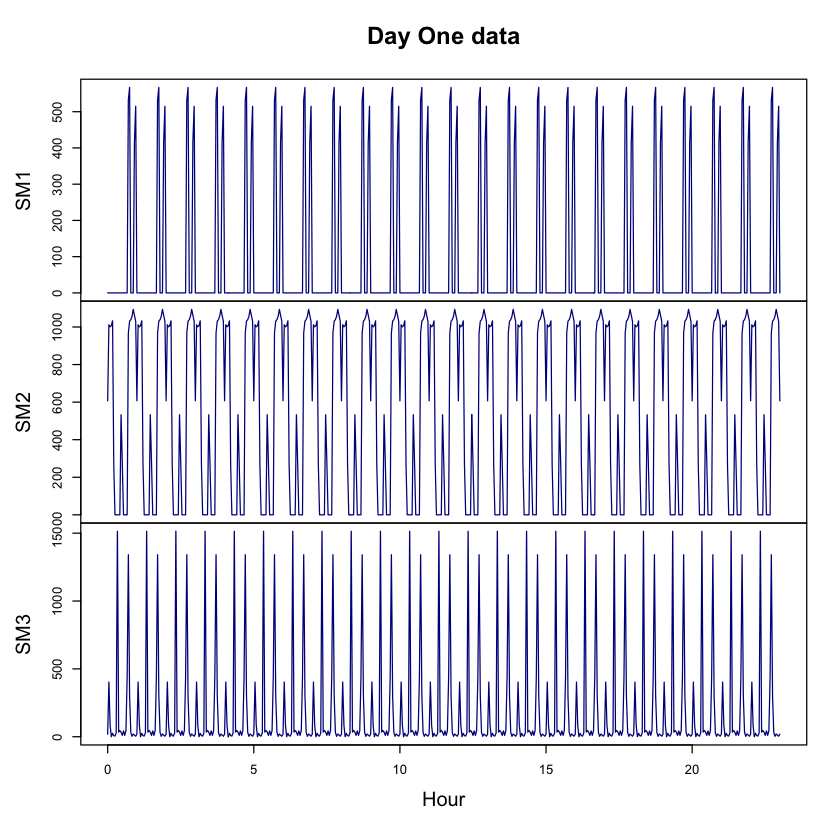

In [13]:
plot(TS_day, xlab="Hour", ylab="Consumption", main="Day One data", type="l", col="darkblue")

# Monthly Aggregate data from 2006 Dec to 2011 Nov

In [14]:
Powerdata_month <- PowerConsumption[,2:12] %>%
  group_by(month) %>%
  summarise(SM1=sum(Sub_metering_1, na.rm=TRUE),
            SM2=sum(Sub_metering_3, na.rm=TRUE),
            SM3=sum(Sub_metering_2, na.rm=TRUE))
TS_month<-ts(Powerdata_month[,2:4], frequency=12)
head(TS_month)

SM1,SM2,SM3
181860,1129112,198365
86646,657360,137175
204458,1216629,224592
184142,1234072,225524
246732,1367272,271705
126258,762891,177036


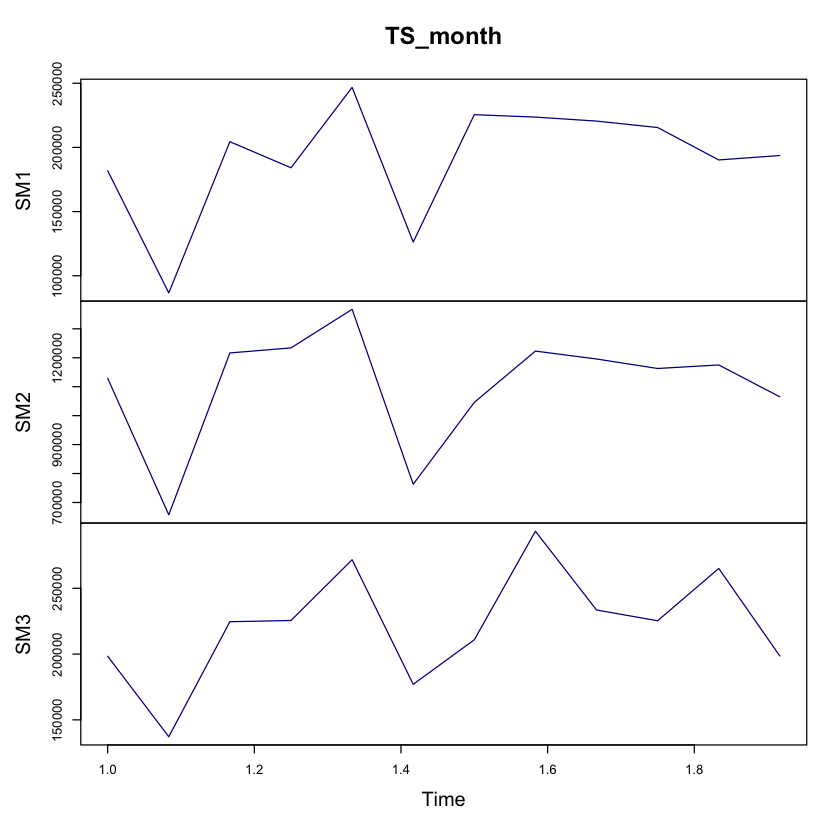

In [15]:
plot(TS_month, col="darkblue")

# Yearly Data

In [16]:
Powerdata_year <- PowerConsumption[,2:12] %>%
  group_by(month, year) %>%
  summarise(SM1=sum(Sub_metering_1, na.rm=TRUE),
            SM2=sum(Sub_metering_3, na.rm=TRUE),
            SM3=sum(Sub_metering_2, na.rm=TRUE))
TS_year<-ts (Powerdata_year[,3:5], start=c(2006), end=c(2012), frequency = 4)
head(TS_year)

SM1,SM2,SM3
42078,189503,38417
47080,295678,70871
54506,307840,52601
38196,336091,36476
36251,225442,49711
3873,79665,22264


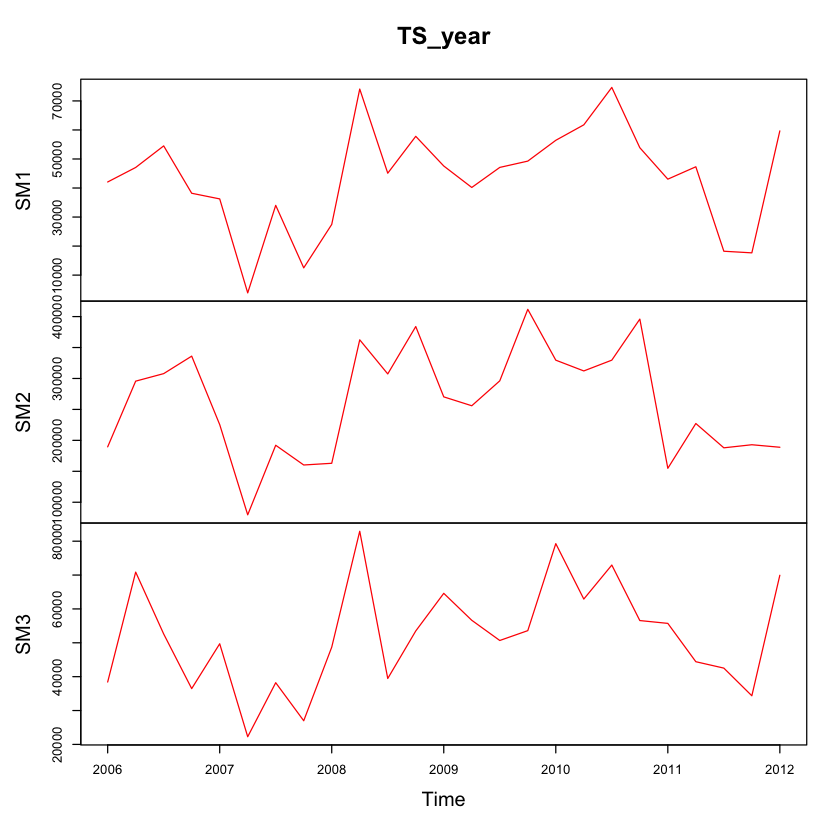

In [17]:
plot(TS_year, col=rainbow(10))

# Based on the above graph, we can see that the power consumption was 
# highest for all three meters in year 2008, so we will break down to quarterly 
# data for year 2008

In [18]:
Powerdata_2008_Q1<-subset(Powerdata_year, year=="2008" & (month=="Jan" | month=="Feb" | month=="Mar"))
TS_2008_Q1<-ts(Powerdata_2008_Q1[,3:5])

In [19]:
Powerdata_2008_Q2<-subset(Powerdata_year, year=="2008" & (month=="Apr" | month=="May" | month=="Jun"))
TS_2008_Q2<-ts(Powerdata_2008_Q2[,3:5])

In [20]:
Powerdata_2008_Q3<-subset(Powerdata_year, year=="2008" & (month=="Jul" | month=="Aug" | month=="Sep"))
TS_2008_Q3<-ts(Powerdata_2008_Q3[,3:5])

In [21]:
Powerdata_2008_Q4<-subset(Powerdata_year, year=="2008" & (month=="Oct" | month=="Nov" | month=="Dec"))
TS_2008_Q4<-ts(Powerdata_2008_Q4[,3:5])

In [22]:
install.packages("PerformanceAnalytics")
library(PerformanceAnalytics)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last


Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend



Warning message in xy.coords(x = matrix(rep.int(tx, k), ncol = k), y = x, log = log):
“NAs introduced by coercion”Warning message in xy.coords(x, y):
“NAs introduced by coercion”Warning message in xy.coords(x = matrix(rep.int(tx, k), ncol = k), y = x, log = log):
“NAs introduced by coercion”Warning message in xy.coords(x, y):
“NAs introduced by coercion”Warning message in xy.coords(x = matrix(rep.int(tx, k), ncol = k), y = x, log = log):
“NAs introduced by coercion”Warning message in xy.coords(x, y):
“NAs introduced by coercion”Warning message in xy.coords(x = matrix(rep.int(tx, k), ncol = k), y = x, log = log):
“NAs introduced by coercion”Warning message in xy.coords(x, y):
“NAs introduced by coercion”

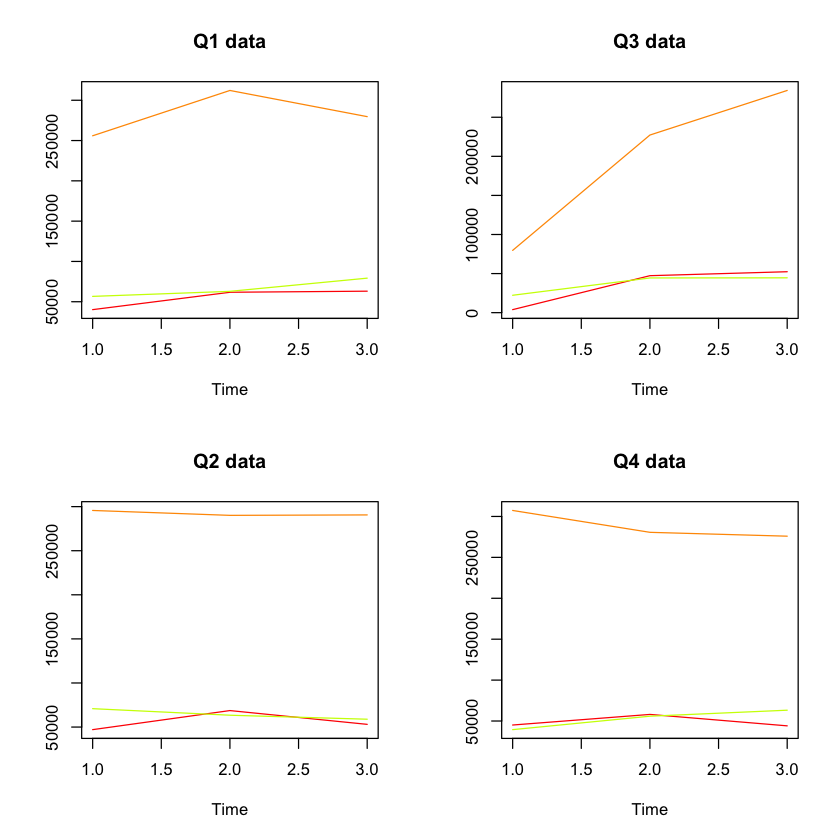

In [23]:
par(mfcol=c(2,2))
ts.plot(TS_2008_Q1, plot.type="s", main="Q1 data", gpars= list(col=rainbow(10)))
ts.plot(TS_2008_Q2, plot.type="s", main="Q2 data", gpars= list(col=rainbow(10)))
ts.plot(TS_2008_Q3, plot.type="s", main="Q3 data", gpars= list(col=rainbow(10)))
ts.plot(TS_2008_Q4, plot.type="s", main="Q4 data", gpars= list(col=rainbow(10)))

# Holt winters for year 2006-2012 for SM1(Sub meter 1) and projected quarterly demand until 2015

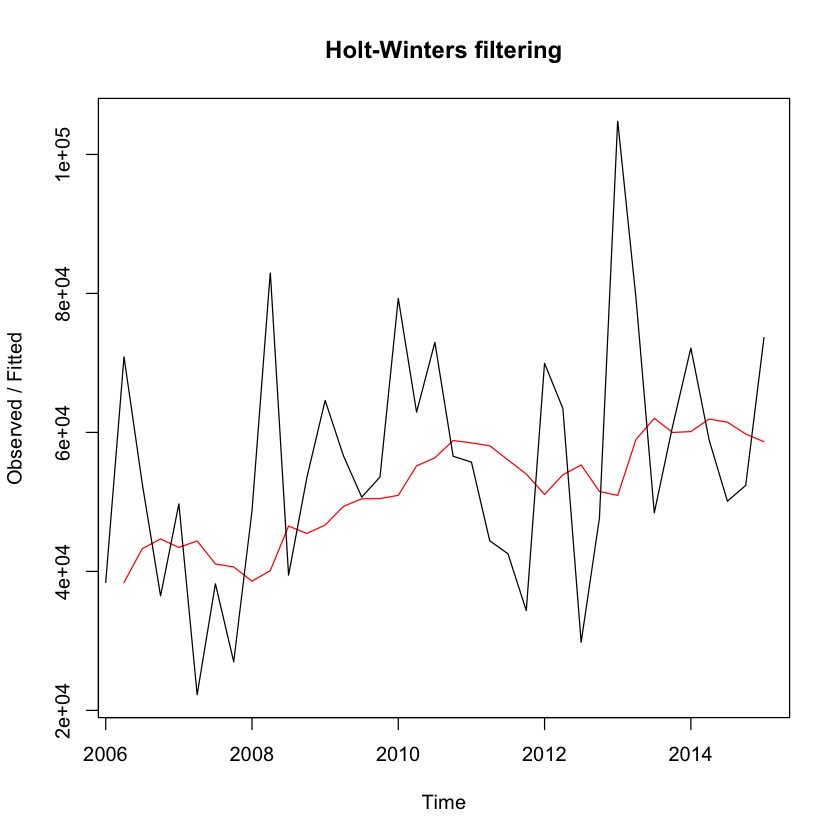

In [24]:
TS_year<-ts (Powerdata_year[,3:5], start=c(2006), end=c(2015), frequency = 4)
holt<-HoltWinters(TS_year[,3], beta = FALSE, gamma = FALSE)  
plot(holt)

In [25]:
#install.packages("forecast")
library(forecast)

# Plot SM1 Holt Winter quarterly forecast starting from year 2007
# Frequency = 4 

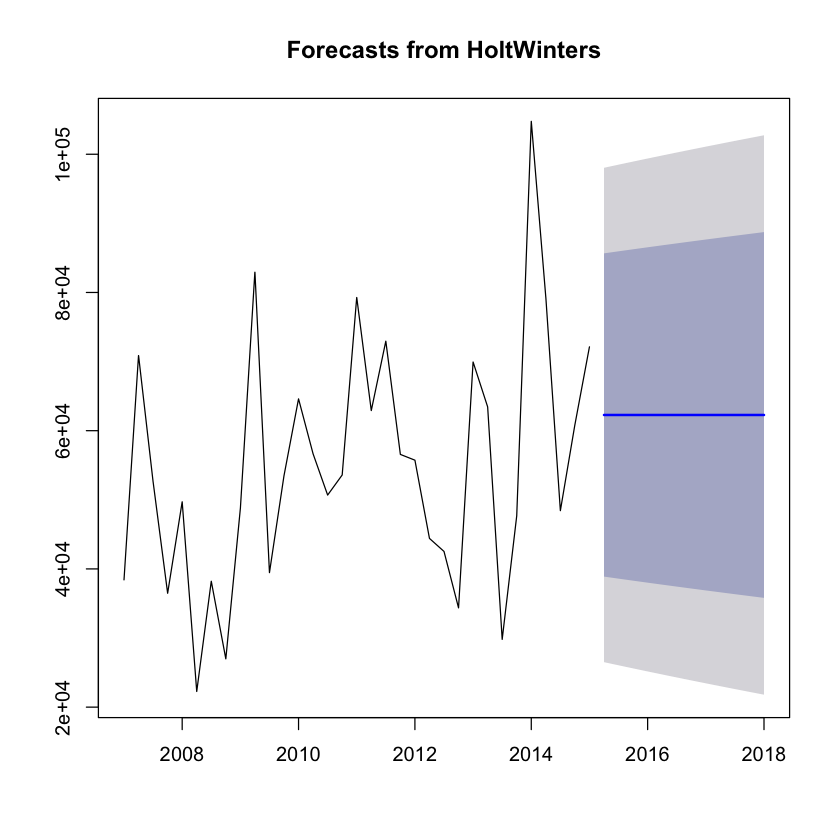

In [26]:
plot(
  forecast(
    HoltWinters(
      ts(TS_year[,3], start=c(2007), end=c(2015), frequency=4), 
      beta=FALSE, gamma=FALSE
    ), 
    h=12
  )
)


# Decompose the data for SM1 for years 2007-2012

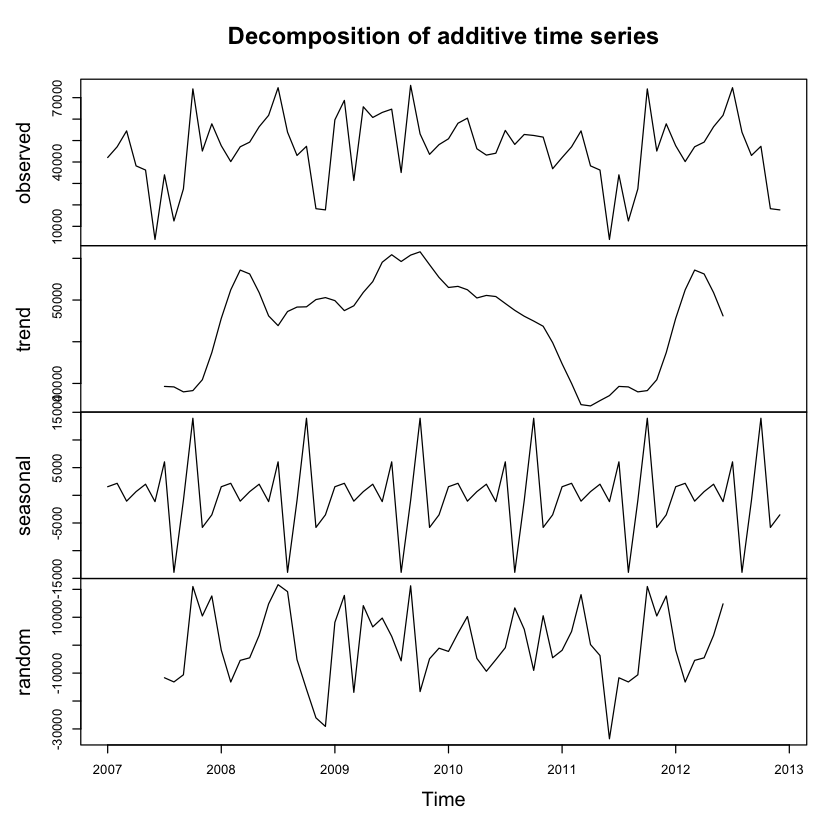

In [27]:
TS_year<-ts(Powerdata_year[,3], start=c(2007,1), end=c(2012,12), frequency = 12)
TScomponent<-decompose(TS_year)
season<-TScomponent$seasonal
trend<-TScomponent$trend

plot(TScomponent)  

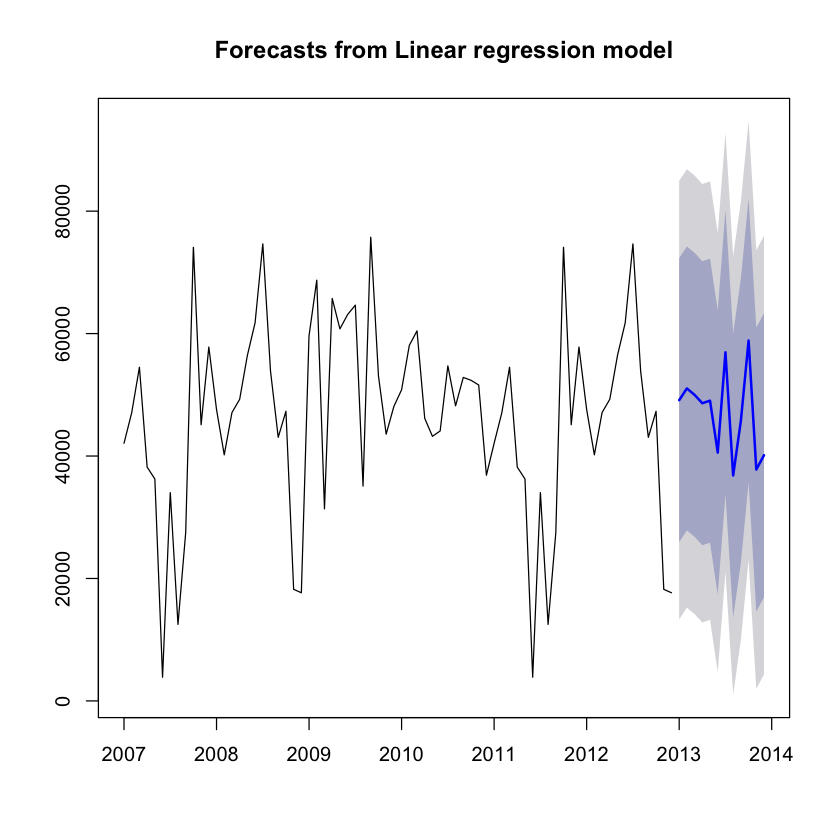

In [28]:
plot(
  forecast(
    tslm(TS_year
         ~ trend + season),
    h=12
  )
)

# Season ggplot

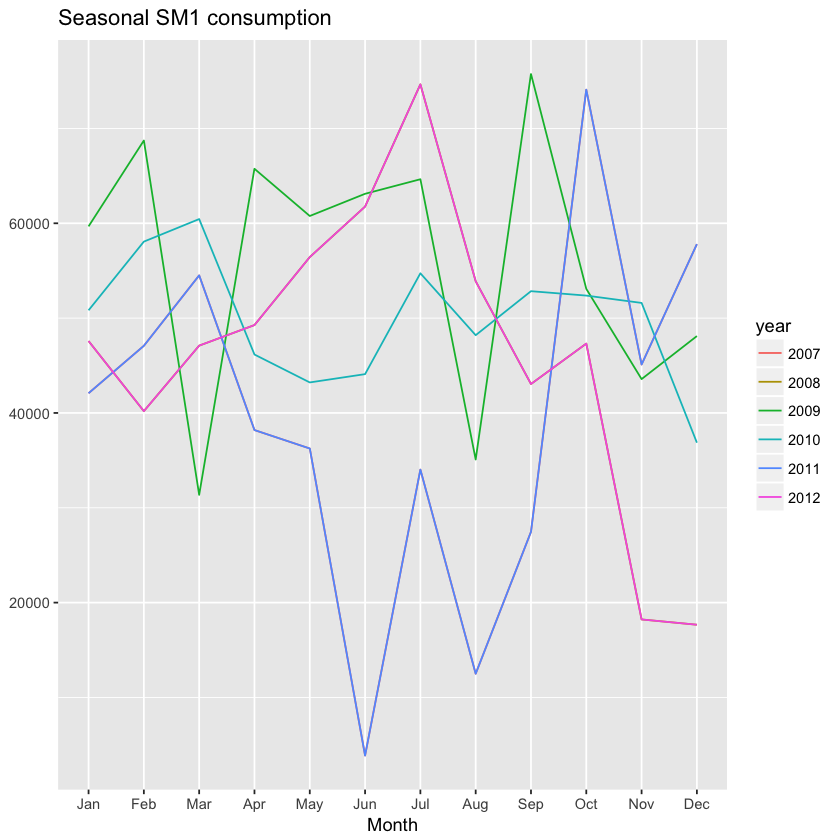

In [30]:
ggseasonplot(TS_year, main="Seasonal SM1 consumption")